In [13]:
import pandas as pd
from pathlib import Path

In [17]:
ROOT_PATH = Path("Data/pneumonia_classification/stage_2_train_images")
SAVE_PATH = Path("Data/Processed/heart_detection")

In [19]:
labels = pd.read_csv("Data/heart_detection/rsna_heart_detection.csv")

In [20]:
labels.head()

,label,x0,y0,w,h,name,img_shape_x,img_shape_y
0,heart,91,71,77,102,ca112a3c-b701-48b8-a94f-725ea65416a7,224,224
1,heart,70,64,89,67,e5f292ae-f1e5-497c-b0a0-68f1aa2196b2,224,224
2,heart,82,55,81,76,67af68f7-7ba0-49a0-a373-3a8801eb0faa,224,224
3,heart,93,74,78,89,814289a3-9ce8-4cba-842f-45d6a36f540d,224,224
4,heart,85,61,85,93,e508969f-c931-462b-aa90-ccde34a4d9e5,224,224


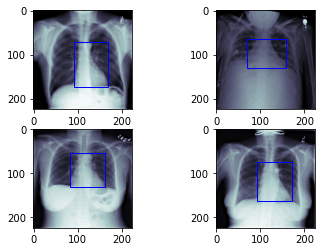

In [29]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import cv2
import pydicom

fig, axis = plt.subplots(2, 2)

c = 0
for i in range(2):
    for j in range(2):
        data = labels.iloc[c]
        name = data["name"]

        image_path = ROOT_PATH/str(name)
        image_path = image_path.with_suffix(".dcm")

        image_file = pydicom.read_file(image_path)
        image = image_file.pixel_array
        image = cv2.resize(image, (224, 224))

        x = data["x0"]
        y = data["y0"]
        width = data["w"]
        height = data["h"]


        axis[i][j].imshow(image, cmap="bone")
        rect = patches.Rectangle((x, y), width, height, linewidth=1, edgecolor="b", facecolor="none")
        axis[i][j].add_patch(rect)
        
        c += 1


In [35]:
import numpy as np

sums, sums_squared = 0, 0
train_ids = []
val_ids = []

for count, name in enumerate(labels.name):
    image_path = ROOT_PATH/str(name)
    image_path = image_path.with_suffix(".dcm")

    image_file = pydicom.read_file(image_path)
    image = image_file.pixel_array
    image = (cv2.resize(image, (224, 224)) / 255).astype(np.float16)

    train_or_val = "train" if count < 400 else "val"

    if train_or_val == "train":
        train_ids.append(name)
    else:
        val_ids.append(name)

    current_save_path = SAVE_PATH/train_or_val
    current_save_path.mkdir(parents=True, exist_ok=True)

    np.save(current_save_path/name, image)

    normalizer = 224*224
    if train_or_val == "train":
        sums += np.sum(image) / normalizer
        sums_squared += (image ** 2).sum() / normalizer

In [36]:
np.save("Data/Processed/heart_detection/train_subjects", train_ids)
np.save("Data/Processed/heart_detection/val_subjects", val_ids)


In [39]:
len(train_ids), len(val_ids)


(400, 96)

In [42]:
mean = sums / len(train_ids)
std = np.sqrt((sums_squared / len(train_ids)) - mean ** 2)

mean, std

(0.49430165816326493, 0.2527964897943661)